***
# HCI Week 4 - Coronagraphs Part II
*Matthew Kenworthy // Leiden Observatory*

***

Today we cover encircled energy plots and look at telescope PSFs after simulating several coronagraphs.


<div class="alert alert-block alert-info">
<b>IMPORTANT:</b> It is okay to cut and paste and reuse code from your previous practica! I am not expecting you to type everything out again. You now have developed your own codes and plotting routines, please reuse them if you can. This is what most researchers do from day to day.</div>


Today, in [*Questions 4.1*](#part1) *- 4.4*, we will continue calculations to obtain the encircled energy as a function of radius for telescope pupil. You will take a look at different telescope PSFs.

Thereafter, in [*Questions 4.5*](#part2) *- 4.10*, we will simulate different (types/set-ups of) coronographs. 
> *Type 1: Vortex (focal plane) coronagraph*<br>
> *Type 2: The Vortex coronagraph with a secondary obscuration*<br>
> *Type 3: The Apodizing Phase Plate coronagraph*


<div class="alert alert-block alert-info">
<b>Tip:</b> As always, read through the functions defined in the block below, as they may help with the exercises.</div>

Load Python modules into the notebook:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' 

import matplotlib as mpl
mpl.rc('image', interpolation='nearest', origin='lower')

def displC(c,trim=0):
    """displC - display a Complex number c as four plots
    
               The top two plots are (Real, Imaginary) quantities
               The bottom two plots are (Amplitude, Phase)
               
               Optionally cut out the central square  with a size of 'trim x trim' pixels"""   
    c2 = np.copy(c)
    if (trim>0): # if the user specifies a trim value, cut out the centre of the image
        (nx,ny) = c.shape
        dx = int((nx-trim) / 2)
        dy = int((nx-trim) / 2)
        c2 = c[dx:dx+trim,dy:dy+trim]
        
    # set up the plot panels
    fig=plt.figure(figsize=(10,8))
    axre = fig.add_subplot(221)
    axim = fig.add_subplot(222)
    axamp = fig.add_subplot(223)
    axpha = fig.add_subplot(224)
    # plot out the panels
    im = axre.imshow(c2.real)
    im = axim.imshow(c2.imag)
    im = axamp.imshow(np.abs(c2))
    im = axpha.imshow(np.angle(c2))
    
    axre.set_title('Real')
    axim.set_title('Imag')
    axamp.set_title('Amplitude')
    axpha.set_title('Phase')
    plt.show()

    
def plotCAmpl(Iorig, GAMMA=4, RANGE=None, plotnow=True, trim=0, title="plotCAmpl output"):
    """plotCAmpl - display a complex valued image by taking a complex 2D array 
        as input and returning an [N,3] RGB image for display

        if RANGE=(min,max) is given, it will set image intensity
        to 0 and 1 for these values and BLACK and WHITE
        colours for out of range amplitude values respectively

        the returned image has AMPLITUDE as brightness and
        PHASE as colour:

        RED    YELLOW   BLUE   GREEN
        0        90     180     270  degrees phase

        The image is scaled by a GAMMA factor (defaults to 4)
        to emphasize smaller amplitudes

        Set plotnow=False to stop display

        Returns a MxNx3 image suitable for display
    """
    import numpy as np
    PI = 4 * np.arctan(1)
    I = np.copy(Iorig)
    if (trim>0): # if the user specifies a trim value, cut out the centre of the image
        (nx,ny) = I.shape
        dx = int((nx-trim) / 2)
        dy = int((nx-trim) / 2)
        I = I[dx:dx+trim,dy:dy+trim]
        
    # calculate amplitude
    ampl = (abs(I)).real

    if RANGE is None:
        ampl = ampl / np.amax(ampl)
    else:
        ampl = (ampl - RANGE[0]) / abs(RANGE[1] - RANGE[0])
        ampOVER  = (ampl > 1)
        ampUNDER = (ampl < 0)
        ampl[ampOVER]  = 1
        ampl[ampUNDER] = 0

    # apply gamma to amplitude
    ampl = np.power(ampl, 1./GAMMA)

    # normalise phase from 0 to 1
    phse = (np.angle(I) / (2*PI)) + 0.5

    # make an RGB array
    img = np.zeros((I.shape[0], I.shape[1], 3), dtype=float)

    # red
    red = abs(phse - 0.625) * 4 - 0.5
    red = np.maximum(red, 0)
    red = np.minimum(red, 1)

    # green
    grn = 2 - abs(phse - 0.5) * 4
    tmp = np.where(grn > 1)
    grn[tmp] = 2. - grn[tmp]

    # blue
    blu = 1 - abs(phse - 0.5) * 4
    blu = np.maximum(blu, 0)

    img[:,:,0] = ampl * red
    img[:,:,1] = ampl * grn
    img[:,:,2] = ampl * blu
    
    titles = ['red', 'green', 'blue', 'rgb image']

    # mark out of range points with RGB color
    if RANGE:
        img[ampOVER,:]  = (1,1,1)
        img[ampUNDER,:] = (0,0,0)


    if plotnow:
        # modified for ipython notebooks
        fig, ax = plt.subplots(1, figsize=(6,6)) 
        ax.set_xlabel("x");   ax.set_ylabel("y")  
        ax.set_title("{}".format(title))
        ax.imshow(img, aspect='equal',vmin = 0., vmax = 1., interpolation='nearest')
        plt.show()

        
    return(img)   
    
    
def padcplx(c,pad=5):
    """padcplx - puts a `Complex` array into the centre of a zero-filled `Complex` array
               pad is an integer defining the padding multiplier for the output array """
    (nx, ny) = c.shape
    bignx = nx*pad
    bigny = ny*pad
    big_c = np.zeros((bignx,bigny),dtype=complex)

    dx = int((nx * (pad-1)) / 2)
    dy = int((ny * (pad-1)) / 2)

    big_c[dx:dx+nx,dy:dy+ny] = c
    return(big_c)

def FFT(c,pad=5):
    """FFT - carry out a complex Fourier transform (with optional padding)
            c - the input 2D Complex numpy array
            pad - integer multiplier for the padding/sampling
            Returns the `Complex` FFT padded array"""
    from numpy.fft import fft2,fftshift,ifft2,ifftshift
    psfA = fftshift(fft2(ifftshift(padcplx(c,pad))))
    return psfA

def IFFT(cb,pad=5):
    """IFFT - carry out the complex Fourier transform (with optional padding)
            and return the FFT padded array"""
    from numpy.fft import fft2,fftshift,ifft2,ifftshift
    psfB = fftshift(ifft2(ifftshift(padcplx(cb,pad))))
    return psfB

def circle_mask(im, xc, yc, rcirc):
    """circle_mask - function that takes the input 2D array 'im' that evaluates the equation 
            (x-x_c)^2 + (y-y_c)^2 < r^2 with circle center coordinates (x_c, y_c) and a radius 'r'
            as input parameters and return a mask array with the same shape as 'im'."""
    ny, nx = im.shape
    y,x = np.mgrid[0:nx,0:ny]
    r = np.sqrt((x-xc)*(x-xc) + (y-yc)*(y-yc))
    return ( (r < rcirc))

def r_theta(im, xc, yc):
    """r_theta - make a radius mask and return the radius rr and the angle phi for point (xc,yc)"""
    ny, nx = im.shape
    yp, xp = np.mgrid[0:ny,0:nx]
    yp = yp - yc
    xp = xp - xc
    rr = np.sqrt(np.power(yp,2.) + np.power(xp,2.))
    phi = np.arctan2(yp, xp)
    return(rr, phi)

def phi_ramp(im, npx, npy):
    """phi_ramp - make an X-ramp, making the 0 be in the middle, 
            make it -0.5 to +0.5 and make it -pi to +pi. """
    ny, nx = im.shape
    ly = np.linspace(-0.5, 0.5, ny) * np.pi * npy * 2
    lx = np.linspace(-0.5, 0.5, nx) * np.pi * npx * 2
    
    x, y = np.meshgrid(lx, ly) 
    return(x+y)

def coro(A, m, N, nsamp):
    """coro - simulated Lyot coronograph taking a telescope pupil 'A', transmissive masks 'm' and 'N'
            and a sampling number 'nsamp' that returns  the final science camera focal plane image 'F' 
            and all the intermediate planes, 'B', 'C', 'D', and 'E'."""
    B = FFT(A,nsamp)
    #normalize B according to previous found relation
    #norm = nsamp**2*A.shape[0]**2
    #B = B/np.sqrt(norm)
    C = m * B
    D = IFFT(C,1)
    E = N * D
    F = FFT(E,1)

    return(B,C,D,E,F)
 

In [2]:
# you can use your own routines if you prefer

def Isum(c):
    """Isum - routine that calculate the summed (real) intensity of a complex amplitude input image, c"""
    return (np.sum(c * c.conjugate()).real)

def xaxis_energy(im, xr):
    """xaxis_energy - takes a complex image im, cuts out the line of pixels from -xr to +xr
            across the middle of the image and returns the energy per pixel along that line"""
    ny, nx = im.shape
    xc = int((nx-1) / 2.)
    yc = int((ny-1) / 2.)
    sli = im[yc,xc-xr:xc+xr+1]
    return((sli*np.conjugate(sli)).real)

def ee(im, xc, yc, r_ap):
    """ee - calculate the fraction of encircled energy within a circular aperture of radius 'r_ap'
            centered at (xap, yap) in the complex imput image 'im'. Returns encircled energy"""
    r, t = r_theta(im, xc, yc)
    
    eout = np.zeros_like(r_ap)
    for i, rnow in enumerate(r_ap):
        eout[i] = Isum(im * (r < rnow))
    return(eout)
    

<a id='part1'></a>

## Encircled Energy (continued from last week)
Last week you calculated the PSF profile and encircled energy for filled circular telescope pupils. Recall that the encircled energy is the *fraction of the total integrated flux in an image contained within a given radius r*.

Many telescopes have a large primary mirror that reflects the light onto a secondary mirror, which then forms the focus of the telescope at either a Cassegrain, Gregorian, or Naysmith focus. The secondary mirror blocks light from the centre of the primary telescope, along with the shadows of the secondary support struts that hold the secondary mirror above the primary mirror. This is referred to as the *secondary obscuration*.

Let us take a look at the encircled energy for secondary obscurations. 

---
<span style="  font-size:2em; color: SteelBlue;">Question 4.1</span> <span style="  font-size:1em; color: SteelBlue;">
(6 points): </span>

**Calculate encircled energy plots for 0, 15, and 30 percent secondary obscuration in the center of the telescope pupil.**

1. **Assume the same telescope pupil geometry as previous week: a square array `A` (101 by 101 pixels) with the pupil touching all four edges of the square. The total intensity of `A` was `100.0` intensity units.**
* **Assume the secondary obscuration is circular and concentric with the telescope pupil. The obscuration is completely opaque which implies it had an amplitude of zero.** 
* **Normalise the peak of each of the PSFs to unity before transforming to `B`, the first coronagraphic focal plane.**
* **Calculate and (over)plot the encircled energy for all secondary obscurations in one single plot with the x-asis ranging from 0 to 10 $\lambda/D$.**


<div class="alert alert-block alert-info">
<b>Tip:</b> Start from a radius of 1 pixel to avoid a divide by zero error. </div>




**Answer the question: What is the encircled energy at 1.22 $\lambda/D$ for all three (0, 15, and 30 percent) secondary obscuration sizes? Drawing a vertical line might be usefull to obtain the values**

---

With 0.0 percent obscuration, the fraction of encircled energy at 1.22 lambda/D is:  0.84
With 0.15 percent obscuration, the fraction of encircled energy at 1.22 lambda/D is:  0.8
With 0.3 percent obscuration, the fraction of encircled energy at 1.22 lambda/D is:  0.69


<Figure size 864x432 with 0 Axes>

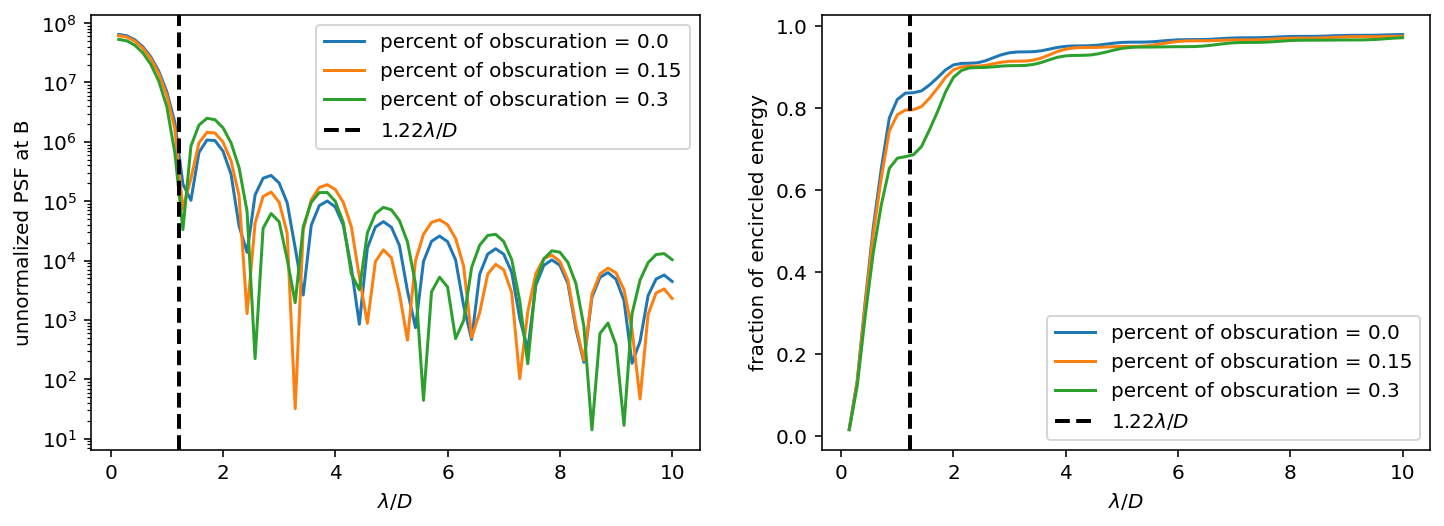

In [3]:
# Q1 code here
dtel = 101 # pixels
y,x = np.mgrid[:dtel, :dtel]
# amplitude equals one for all pixels
ampli = np.ones_like(y)
# zero phase across entire aperture
phase = np.zeros_like(y)  
# make the complex amplitude E
E = ampli * np.exp(1j*phase)
msk = circle_mask(E,50,50,dtel/2)
A  = E.copy()
# mask pixels outside the circle
A[msk==0]=0
# create normalized A with total intensity = 100
norm = Isum(A)
A = A*np.sqrt(1e2/norm)
nsamp=7
r_ap = np.arange(1,10*nsamp+1,1)
incrAp = r_ap/nsamp
Percent = [0.00,.15,.30]
plt.figure(figsize=(12,6))
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,4))    
for percent in Percent:
    # add secondary obscuration
    # mask pixels inside obscuration
    obs = circle_mask(E,50,50,dtel/2*percent)
    A[obs==1]=0
    #displC(A)
    # normalize peak of PSF to unity
    A = A/A.max()
    B = FFT(A,nsamp)
    A_energy = xaxis_energy(A,50)
    B_energy = xaxis_energy(B,10*nsamp)
    #B_energy = B_energy/B_energy.max()
    ee_B = ee(B,(B.shape[0]-1)/2,(B.shape[0]-1)/2,r_ap)/Isum(B)
    ax1.semilogy(incrAp,B_energy[10*nsamp:2*10*nsamp],label='percent of obscuration = {}'.format(percent))
    ax2.plot(incrAp,ee_B,label='percent of obscuration = {}'.format(percent))
    ind = np.argmin(np.abs(incrAp-1.22))
    print("With {} percent obscuration,".format(percent),"the fraction of encircled energy at 1.22 lambda/D is: ",np.round(ee_B[ind],2))
ax1.axvline(x=1.22,color='k',ls='--',lw=2,label='$1.22\lambda/D$')
ax2.axvline(x=1.22,color='k',ls='--',lw=2,label='$1.22\lambda/D$')
ax1.set_xlabel(r'$\lambda/D$')
ax1.set_ylabel('unnormalized PSF at B')
ax2.set_xlabel(r'$\lambda/D$')
ax2.set_ylabel('fraction of encircled energy')
ax1.legend()
ax2.legend()
plt.show()
# Q1 end of code


In [4]:
# Q1 answer here


print ('The fractions of encircled energy at 1.22 lambda/D are: 0.84,0.80,0.69, respectively.')



# Q1 end of answer


The fractions of encircled energy at 1.22 lambda/D are: 0.84,0.80,0.69, respectively.


---
<span style="  font-size:2em; color: SteelBlue;">Question 4.2</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>

**What happens to the relative intensities of the first and second Airy rings as the secondary obscuration size increases?**

---

In [5]:
# Q2 answer here

print("By looking at the left plot above, it can be seen, with increasing obscuration, the relative intensities of the first Airy rings decrease, but the relative intensities of the second Airy rings increase.")
# Q2 end of answer


By looking at the left plot above, it can be seen, with increasing obscuration, the relative intensities of the first Airy rings decrease, but the relative intensities of the second Airy rings increase.


---
<span style="  font-size:2em; color: SteelBlue;">Question 4.3</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>

**Why do the diffraction minima not move significantly as the secondary obscuration increases?**

---

In [6]:
# Q3 answer here

print("Using the small angle approximation, the locations of the minima are dependent on 1) the incident light wavelength, 2) the aperture size. With added obscuuration, neither of the aforementioned condition is changed, so the minima stays almost unchanging.")

# Q3 end of answer


Using the small angle approximation, the locations of the minima are dependent on 1) the incident light wavelength, 2) the aperture size. With added obscuuration, neither of the aforementioned condition is changed, so the minima stays almost unchanging.


### Adding secondary support to our secondary obscuration

We just calculated the encircled energy resulting from secondary obscuration. As mentioned before, additional shadows are caused by secondary supports to the telescope pupil. 

In our telescope we have four struts equally spaced around the circumference of the telescope pupil. They are connecting the edges of the primary mirror to the secondary mirror. All four secondary mirror supports have a width of 5% of the telescope pupil's diameter.

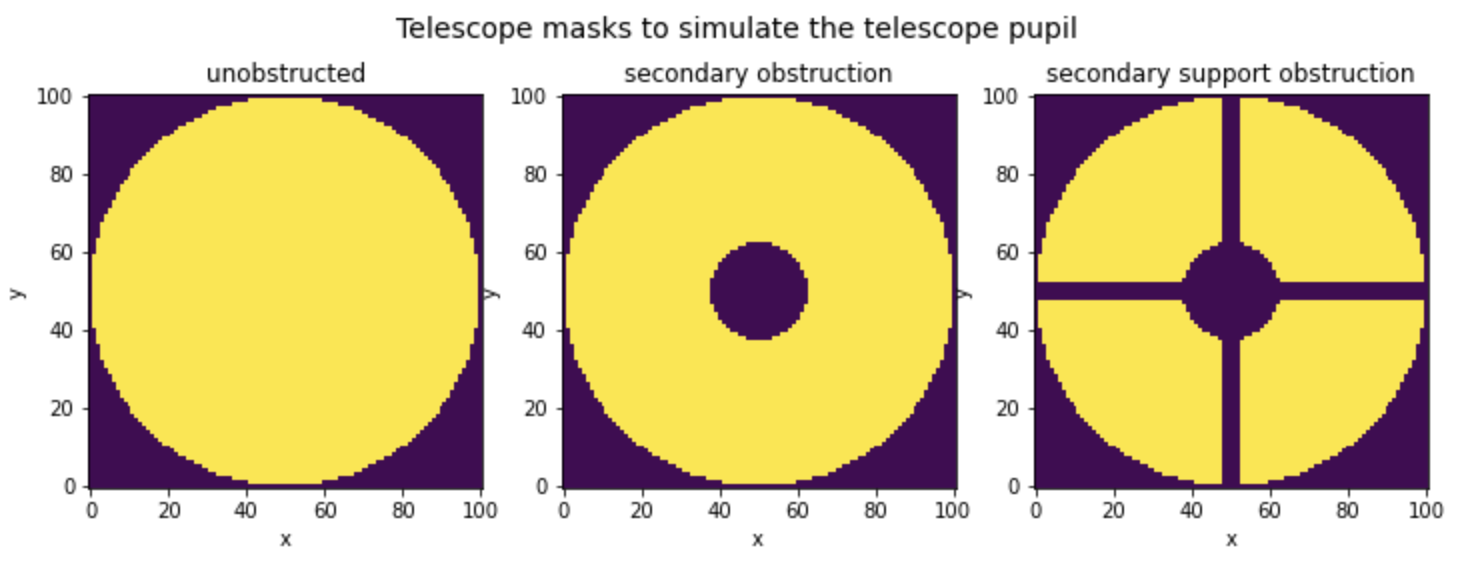

---
<span style="  font-size:2em; color: SteelBlue;">Question 4.4</span> <span style="  font-size:1em; color: SteelBlue;">
(5 points): </span>

**Make three PSF images of the following pupils, and display their log10 signal using `plt.imshow(zoom(np.log10(psf_image / psf_image.max()), 151), vmin=-5)`:**

1. **The unobstructed pupil**
* **A pupil with 20% secondary obscuration (which means that the diameter of the secondary obscuration is 20% of the diameter of the primary mirror)**
* **A pupil with 20% obscuration and the seconday supports described above.**

**Answer the question: What is the effect of the secondary support structures in the PSF?**

---

What is the effect of the secondary support structures in the PSF?

With the secondary support, the Airy rings become disturbed at the locations of the struts.


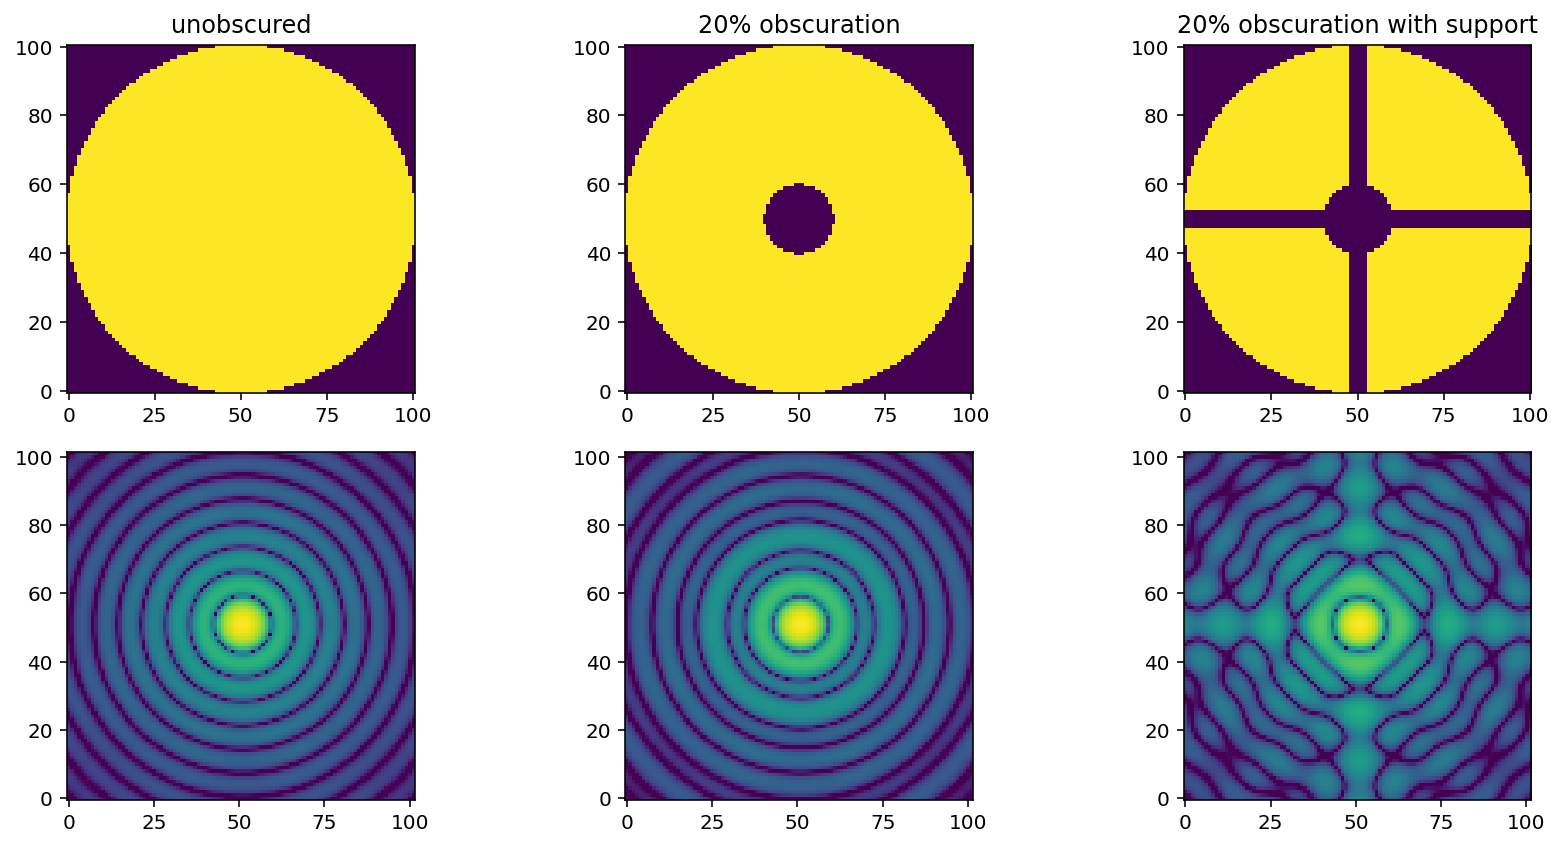

In [7]:
# Q4 code here

def zoom(im,x,y,bb):
    '''zoom - returns a square 2D image cut out from im centered on location (x,y) and with half-width bb'''
    return(im[y-bb:y+bb,x-bb:x+bb])

def support(im,width=.05):
    support = np.zeros_like(im)
    xc = int((im.shape[0]-1)/2)
    yc = xc
    support_scale = int((int(width*im.shape[0])-1)/2)
    support[xc-support_scale:xc+support_scale+1,:]=1
    support[:,yc-support_scale:yc+support_scale+1]=1
    return support

msk = circle_mask(E,50,50,dtel/2)
A  = E.copy()
# mask pixels outside the circle
A[msk==0]=0
# create normalized A with total intensity = 100
norm = Isum(A)
A = A*np.sqrt(1e2/norm)
label = ['unobscured','20% obscuration','20% obscuration with support']
percent = [0,.2,.2]
fig = plt.figure(figsize=(12,6))
for i,lb in enumerate(label):
    ax1 = fig.add_subplot(2,3,i+1)
    ax2 = fig.add_subplot(2,3,i+4)
    obs = circle_mask(E,50,50,dtel/2*percent[i])
    A[obs==1]=0
    if i == 2:
        sp = support(A)
        A[sp==1]=0
    #displC(A)
    # normalize peak of PSF to unity
    A = A/A.max()
    B = FFT(A,nsamp)
    ax1.imshow(np.real(A))
    B_cent = int((B.shape[0]-1)/2)
    psf_image = np.abs(B)**2
    ax2.imshow(zoom(np.log10(psf_image/psf_image.max()),B_cent,B_cent,51),vmin=-5)
    ax1.set_title(lb)
plt.tight_layout()  

# Q4 end of code


# Q4 answer here

print("What is the effect of the secondary support structures in the PSF?\n")
print("With the secondary support, the Airy rings become disturbed at the locations of the struts.")

# Q4 end of answer


<a id='part2'></a>

## More Coronagraphs and the effect of Secondary Obscurations

Last time, you saw that the Lyot coronagraph can suppress on-axis sources. This week, we will look at two other coronagraphs that are used in modern telescopes both on the ground and proposed for space missions. These are some of the *small angle coronagraphs* which can image planets and disks around stars at small angular separations.

### Type 1: Vortex (focal plane) coronagraph

Vortex focal plane coronagraphs are usefull for potential imaging of terrestrial exoplanets in nearby solar systems when used on space-based telescopes. As the name reveals, they make use of vector vortex phase masks.

*How can we simulate a vortex coronagraph?*
In the focal plane mask `m`, a phase ramp is added. This ramp goes from 0 to $n \pi$ radians around a central point, where $n$ denotes the *order* of the vortex. The star is put on the central point of the vortex mask with the planet off to one side. 

A pupil mask `N` then masks out as much of the starlight as possible, while maximising the amount of planet light passing through to the final focal plane `F`. Thus for `N` you want to pick a mask that rejects the star flux but passes the planet flux.

---
<span style="  font-size:2em; color: SteelBlue;">Question 4.5</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>

**Display the on-axis transmission for the $n=4$ vortex coronagraph and off-axis transmission for a planet at $3 \lambda/D$ which is 10000 times fainter in intensity than the central star at position `D`.**

1. **Make a vortex mask `m`, a focal plane mask `m_vor` and pupil plane mask `N_vor`**
2. **Make the star image, and calculate the vortex coronagraph for it**
3. **Make the fainter planet**
4. **Move the planet $3 \lambda/D$ and run the vortex coronagraph on the planet**
5. **Display the pupil at position `D` in the vortex coronagraph for the star and the planet with `plotCAmpl(xxx,151)`.**

**Answer the question: What has happened to the flux of the star and the planet in coronagraph plane `D`?**

---


Star at B


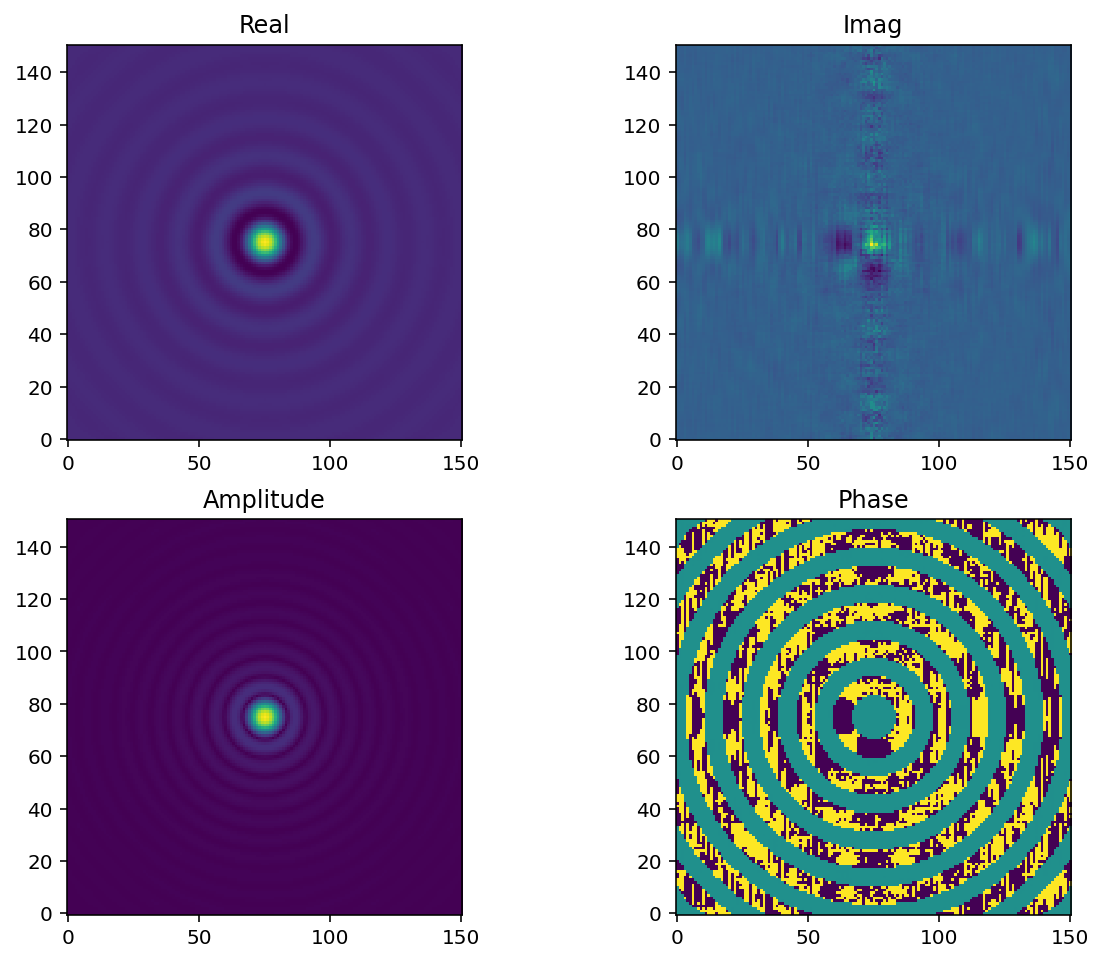

Planet at B


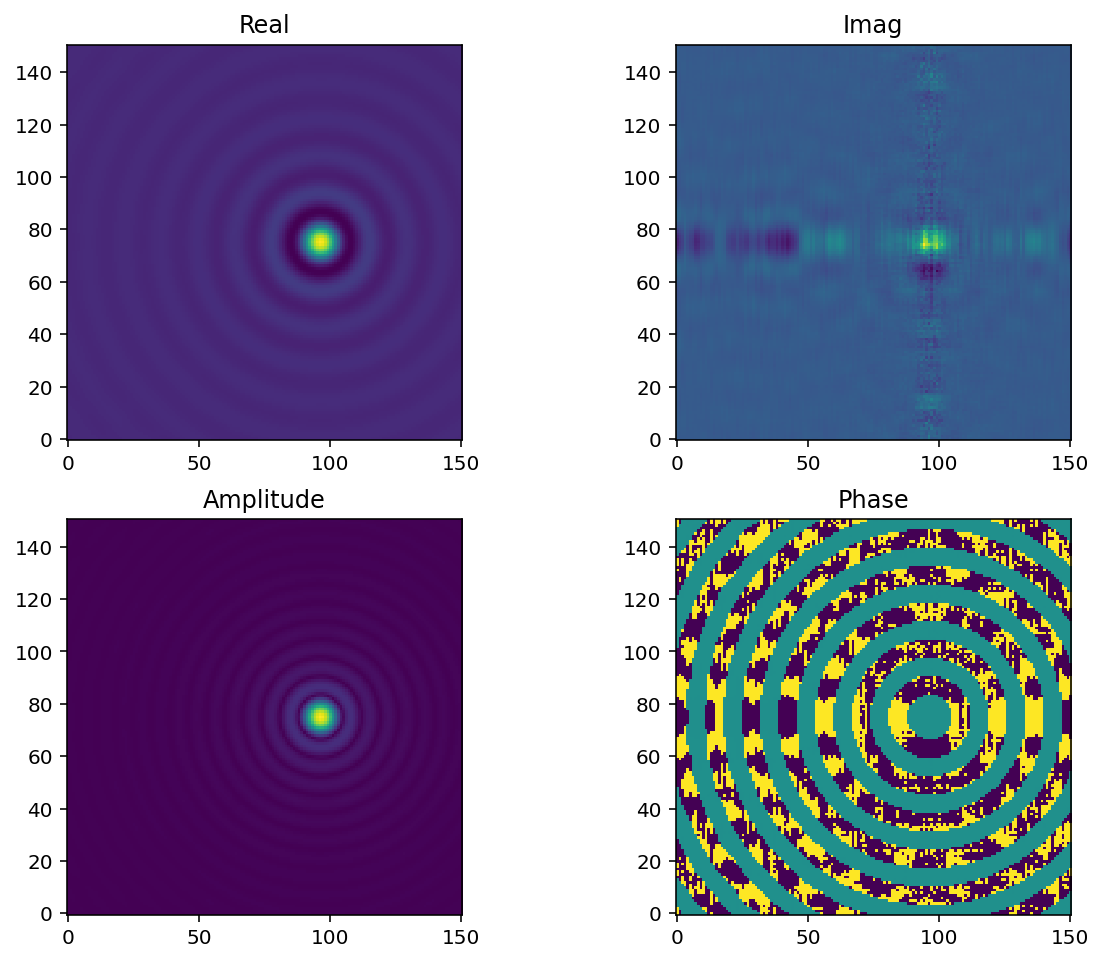

Star and planet at D


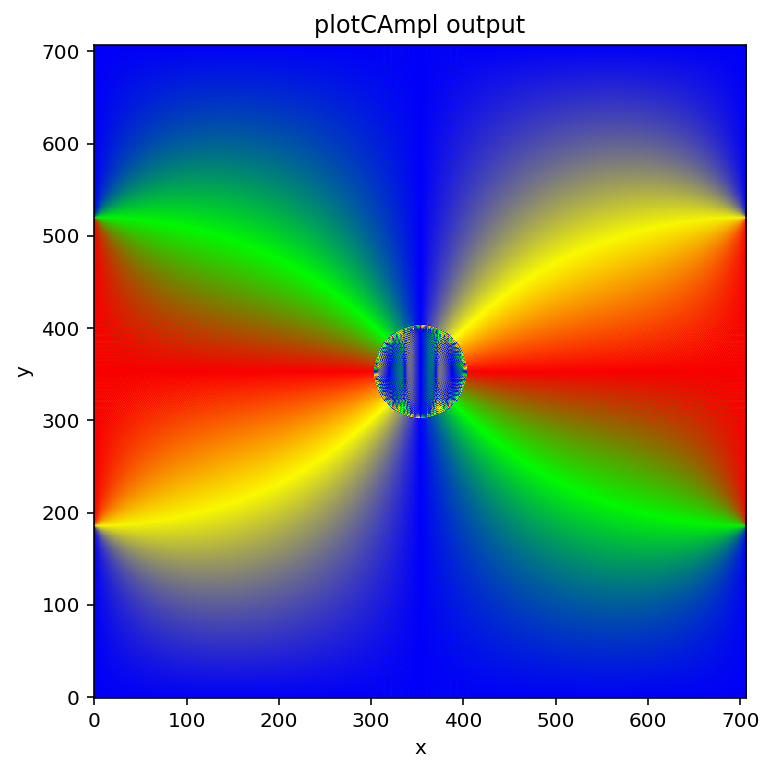

What has happened to the flux of the star and the planet in coronagraph plane `D`?
The flux of the star within the circle is block, however a great amount of stellar flux is still outside the circle defined by the pupil plane A.


In [8]:
# Q5 code here
msk = circle_mask(E,50,50,dtel/2)
A  = E.copy()
# mask pixels outside the circle
A[msk==0]=0
norm = Isum(A)
A = A*np.sqrt(1e2/norm)
A_star = A.copy()
#tilt=phi_ramp(A_star,.2,0)
#A_star=A_star*np.exp(1j*tilt)

# make the focal plane mask m
n = 4
m_r, m_phi = r_theta(B, int((B.shape[0]-1)/2), int((B.shape[0]-1)/2))
m_phase = m_phi*(n/2)+np.pi*n/2
m_ampl = np.ones_like(np.abs(B))
m_vor = m_ampl*np.exp(1j*m_phase)
#displC(m)
# make the planet at 3 lambda/D
Amp_planet = np.real(A_star.copy())/1e2
rp = phi_ramp(Amp_planet,3,0)
A_planet = Amp_planet * np.exp(1j*rp)
N_vor = np.zeros_like(B)
mask = circle_mask(N_vor,int((N_vor.shape[0]-1)/2),int((N_vor.shape[0]-1)/2),int((dtel-1)/2))
N_vor[mask==1]=1
B_star = coro(A_star,m_vor,N_vor,nsamp)[0]
B_planet = coro(A_planet,m_vor,N_vor,nsamp)[0]
print("Star at B")
displC(B_star,151)
print("Planet at B")
displC(B_planet,151)

F_star = coro(A_star,m_vor,N_vor,nsamp)[-1]
F_planet = coro(A_planet,m_vor,N_vor,nsamp)[-1]

D_star = coro(A_star,m_vor,N_vor,nsamp)[2]
D_planet = coro(A_planet,m_vor,N_vor,nsamp)[2]
print("Star and planet at D")
plotCAmpl(D_star+D_planet,151)




# Q5 answer here

print("What has happened to the flux of the star and the planet in coronagraph plane `D`?")
print("The flux of the star within the circle is block, however a great amount of stellar flux is still outside the circle defined by the pupil plane A.")
# Q5 end of answer



---
<span style="  font-size:2em; color: SteelBlue;">Question 4.6</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>

**Show that the star light is rejected by your Lyot pupil plane mask by plotting the cut across the PSF of both star and planet using the `xaxis_energy` from last weeks Practicum. In addition, also plot the star before the coronagraph in plane `B` to show how much starlight has been suppressed. Label the y-axis in `log10` units of normalised intensity, using the telescope PSF with no coronagraph from plane `B` as your reference PSF where the peak intensity is 1. Add a legend to distinguish the three plots.**

---



Star and planet at F


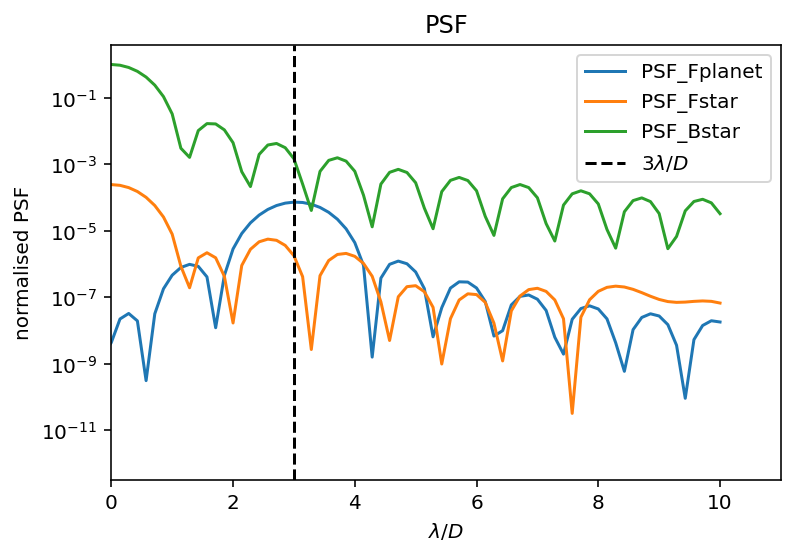

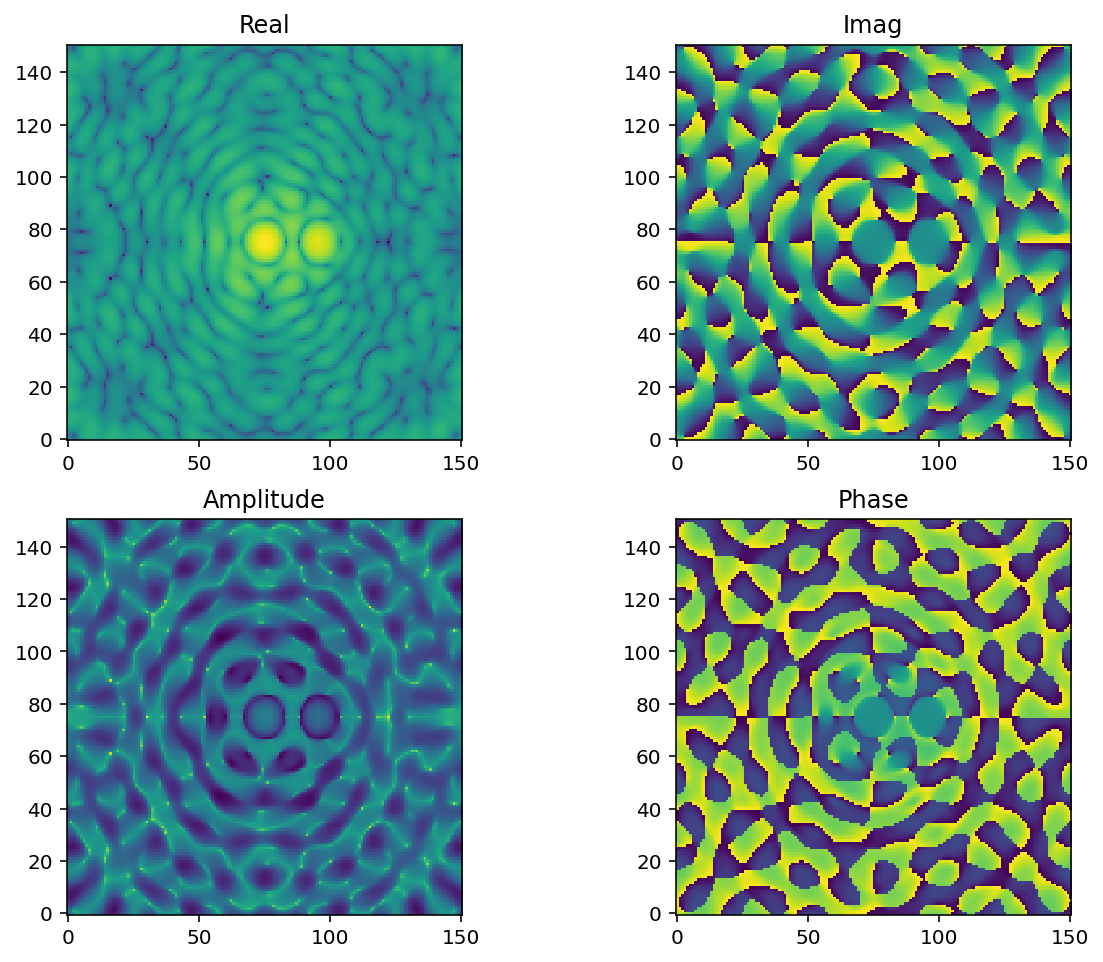

the suppression at the peak of star PSF is:  0.0002450705002307283


In [9]:
# Q6 code here

PSF_Fplanet=xaxis_energy(F_planet,10*nsamp)
PSF_Fstar=xaxis_energy(F_star,10*nsamp)
PSF_Bstar=xaxis_energy(B_star,10*nsamp)
#normalise PSF to the peak of PSF_Bstar
PSF_Fplanet=PSF_Fplanet/np.max(PSF_Bstar)
PSF_Fstar=PSF_Fstar/np.max(PSF_Bstar)
PSF_Bstar=PSF_Bstar/np.max(PSF_Bstar)
#plot PSF
xr=10*nsamp
x=np.arange(-xr,xr+1,1)
incrAp = x/nsamp
plt.semilogy(incrAp,PSF_Fplanet, label='PSF_Fplanet')
plt.semilogy(incrAp,PSF_Fstar,label='PSF_Fstar')
plt.semilogy(incrAp,PSF_Bstar, label='PSF_Bstar')
plt.axvline(x=3,ls='--',color='k',label='3$\lambda/D$')
plt.legend()
plt.xlim([0,None])
plt.xlabel('$\lambda/D$')
plt.ylabel('normalised PSF')
plt.title("PSF")
print("Star and planet at F")
displC(np.log10(F_star+F_planet),151)
suppression=PSF_Fstar.max()/PSF_Bstar.max()
print("the suppression at the peak of star PSF is: ", suppression)
# Q6 end of code

### Type 2: The Vortex coronagraph with a secondary obscuration

Repeat the PSF plots from the previous question for the vortex coronagraph but with a 30% secondary obscuration in the telescope.


---
<span style="  font-size:2em; color: SteelBlue;">Question 4.7</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>

**Repeat the PSF plots from the previous question for the vortex coronagraph but with a 30% secondary obscuration in the telescope.**

---


Star at F


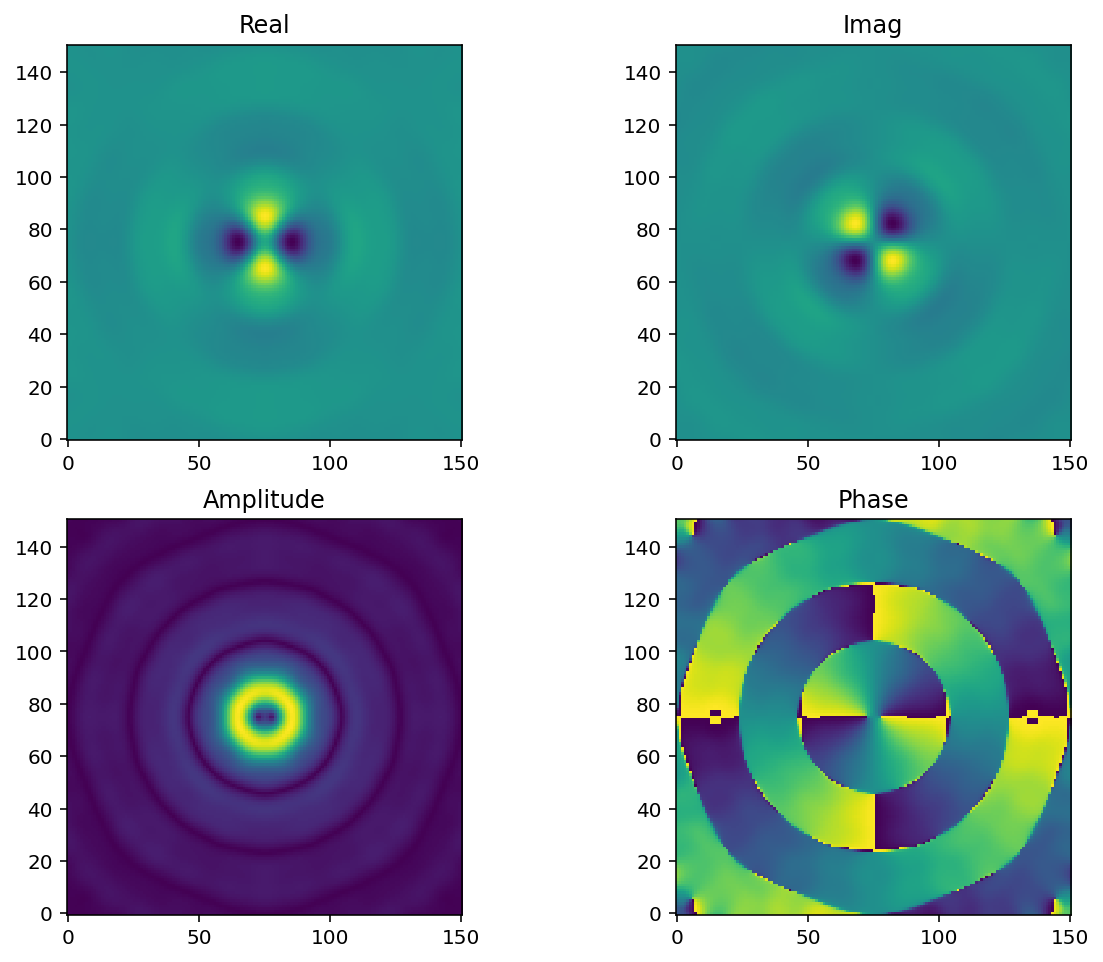

Planet at F


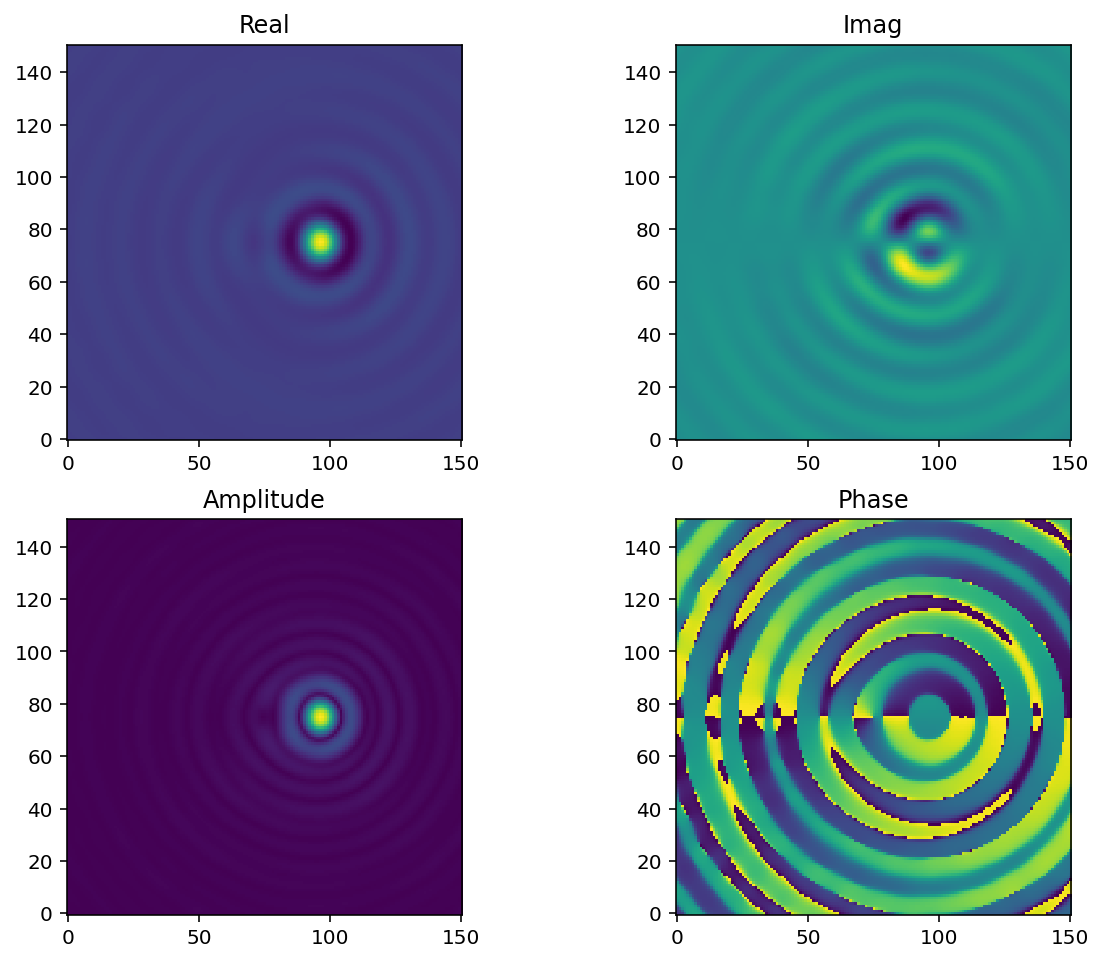

Star and planet at D


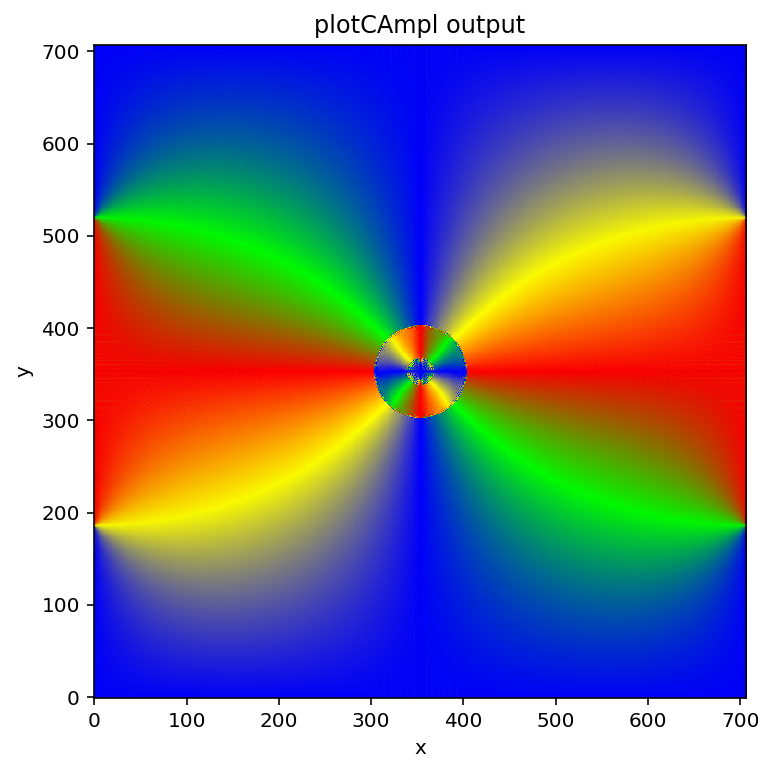

Star and planet at F


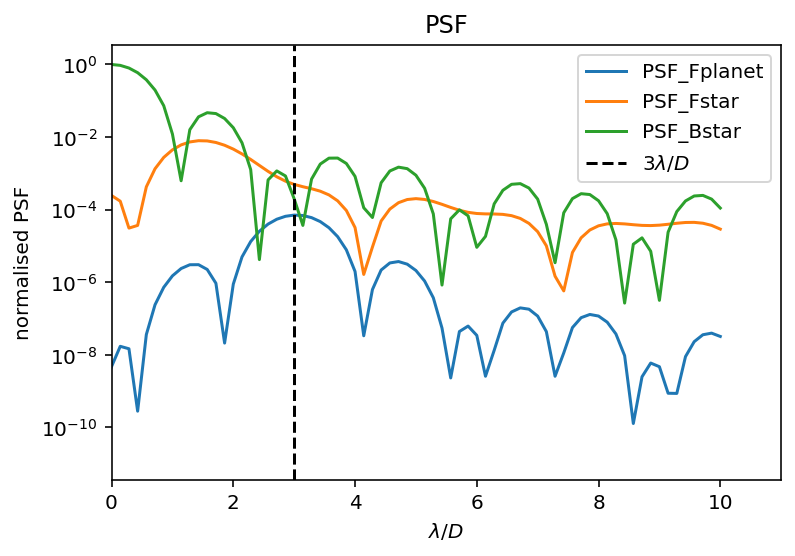

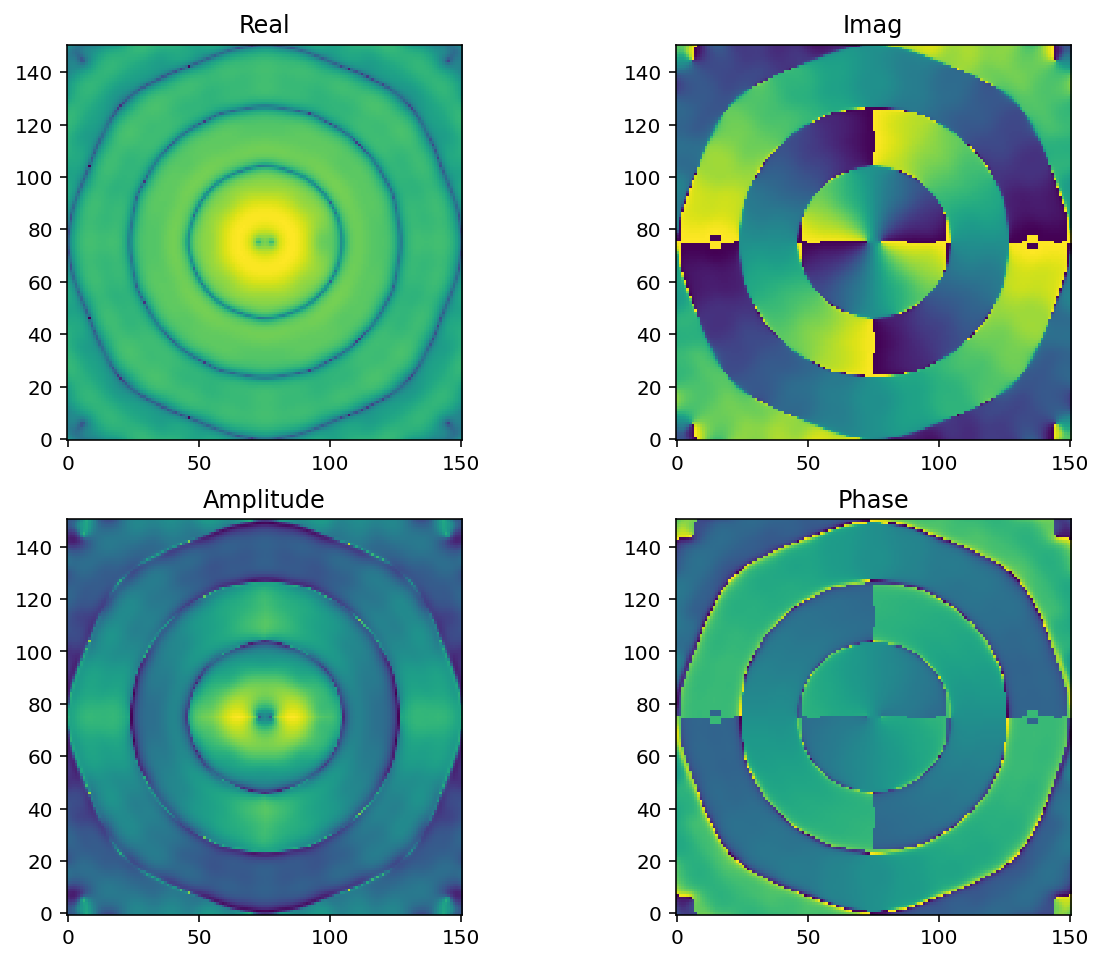

In [10]:
# Q7 code here

A_star = A.copy()
obs = circle_mask(E,50,50,dtel/2*.3)
A_star[obs==1]=0
#tilt=phi_ramp(A_star,.2,0)
#A_star=A_star*np.exp(1j*tilt)

# make the planet at 3 lambda/D
Amp_planet = np.real(A_star.copy())/1e2
rp = phi_ramp(Amp_planet,3,0)
A_planet = Amp_planet * np.exp(1j*rp)
A_planet[obs==1]=0

B_star,C_star,D_star,E_star,F_star = coro(A_star,m_vor,N_vor,nsamp)
B_planet,C_planet,D_planet,E_planet,F_planet = coro(A_planet,m_vor,N_vor,nsamp)
print("Star at F")
displC(F_star,151)
print("Planet at F")
displC(F_planet,151)
print("Star and planet at D")
plotCAmpl(D_star+D_planet,151)

PSF_Fplanet=xaxis_energy(F_planet,10*nsamp)
PSF_Fstar=xaxis_energy(F_star,10*nsamp)
PSF_Bstar=xaxis_energy(B_star,10*nsamp)
#normalise PSF to the peak of PSF_Bstar
PSF_Fplanet=PSF_Fplanet/np.max(PSF_Bstar)
PSF_Fstar=PSF_Fstar/np.max(PSF_Bstar)
PSF_Bstar=PSF_Bstar/np.max(PSF_Bstar)
#plot PSF
xr=10*nsamp
x=np.arange(-xr,xr+1,1)
incrAp = x/nsamp
plt.semilogy(incrAp,PSF_Fplanet, label='PSF_Fplanet')
plt.semilogy(incrAp,PSF_Fstar,label='PSF_Fstar')
plt.semilogy(incrAp,PSF_Bstar, label='PSF_Bstar')
plt.axvline(x=3,ls='--',color='k',label='3$\lambda/D$')
plt.legend()
plt.xlim([0,None])
plt.xlabel('$\lambda/D$')
plt.ylabel('normalised PSF')
plt.title("PSF")
print("Star and planet at F")
displC(np.log10(F_star+F_planet),151)
# Q7 end of code


---
<span style="  font-size:2em; color: SteelBlue;">Question 4.8</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>

1. **Has the on-axis vortex coronagraph suppression increased or decreased?**
2. **What is the effect of the secondary obscuration in the Lyot stop plane?**

---


In [11]:
# Q8 answer here

print("Has the on-axis vortex coronagraph suppression increased or decreased?\n")
suppression1=PSF_Fstar.max()/PSF_Bstar.max()
print("the suppression facor at the peak of star PSF is: ", suppression1)
print("Compared to %f on the above, The on-axis vortex coronagragh suppression has increased.\n" %suppression)

print("What is the effect of the secondary obscuration in the Lyot stop plane?\n")
print("1. The effect is that it blocks stellar flux inside its diameter, but let pass the stellar flux between secondary obscuration and pupil diameter, hence increasing the suppression of the star light.")
print("2. It has little influence on the planet flux.")
# Q8 end of answer

Has the on-axis vortex coronagraph suppression increased or decreased?

the suppression facor at the peak of star PSF is:  0.007934197271168219
Compared to 0.000245 on the above, The on-axis vortex coronagragh suppression has increased.

What is the effect of the secondary obscuration in the Lyot stop plane?

1. The effect is that it blocks stellar flux inside its diameter, but let pass the stellar flux between secondary obscuration and pupil diameter, hence increasing the suppression of the star light.
2. It has little influence on the planet flux.


### Typ3: The APP Coronagraph

The Apodizing Phase Plate (APP) is not a coronagraph in the classical Lyot sense, but it is an apodizer that changes the electric field in the phase but not the amplitude. There is no focal plane mask `m` and you put it in the pupil plane `N`.



---
<span style="  font-size:2em; color: SteelBlue;">Question 4.9</span> <span style="  font-size:1em; color: SteelBlue;">
(4 points): </span>

**Calculate the same plots for star and planet for the APP coronagraph. The APP phase pattern is stored in `app_phse.fits` and the amplitude mask (a 33% secondary obscuration telescope pupil) is in `app_ampl.fits`.**

---



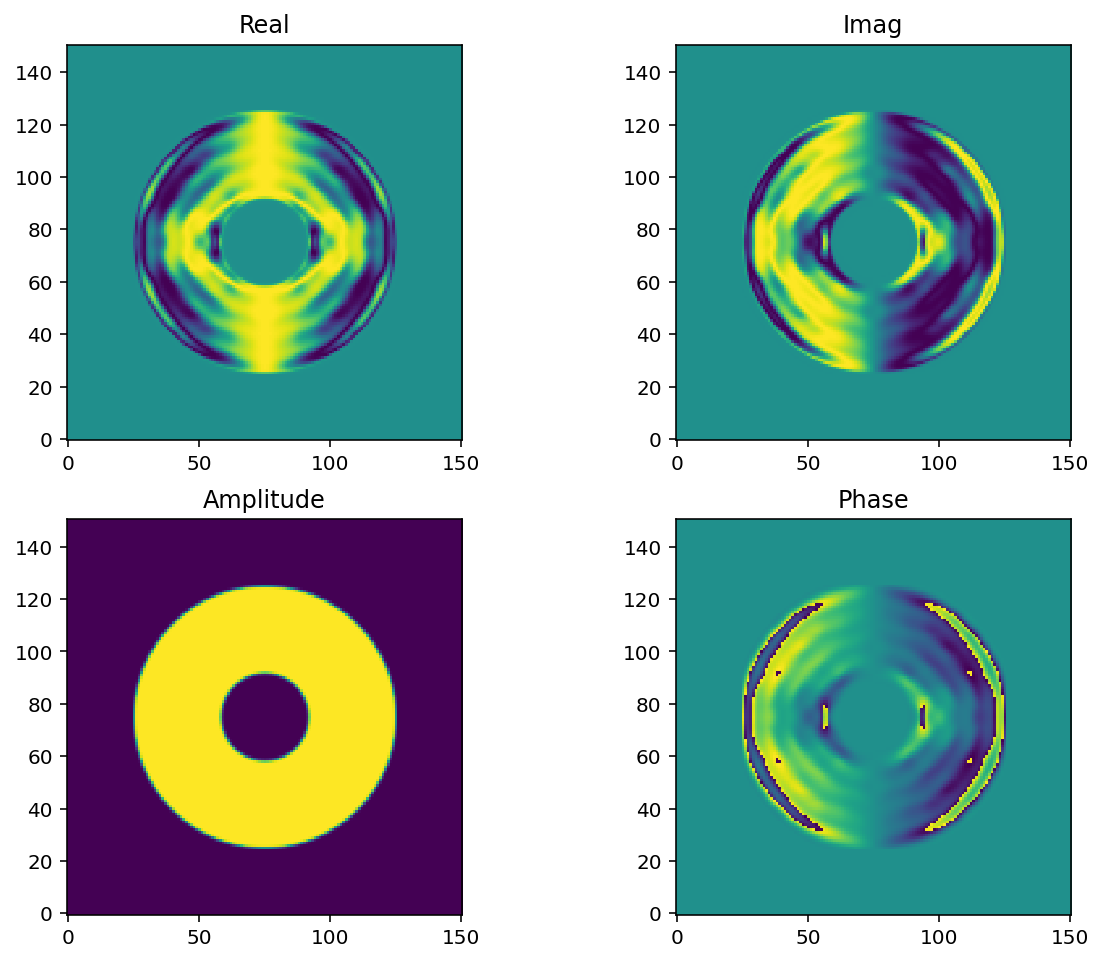

Star at F


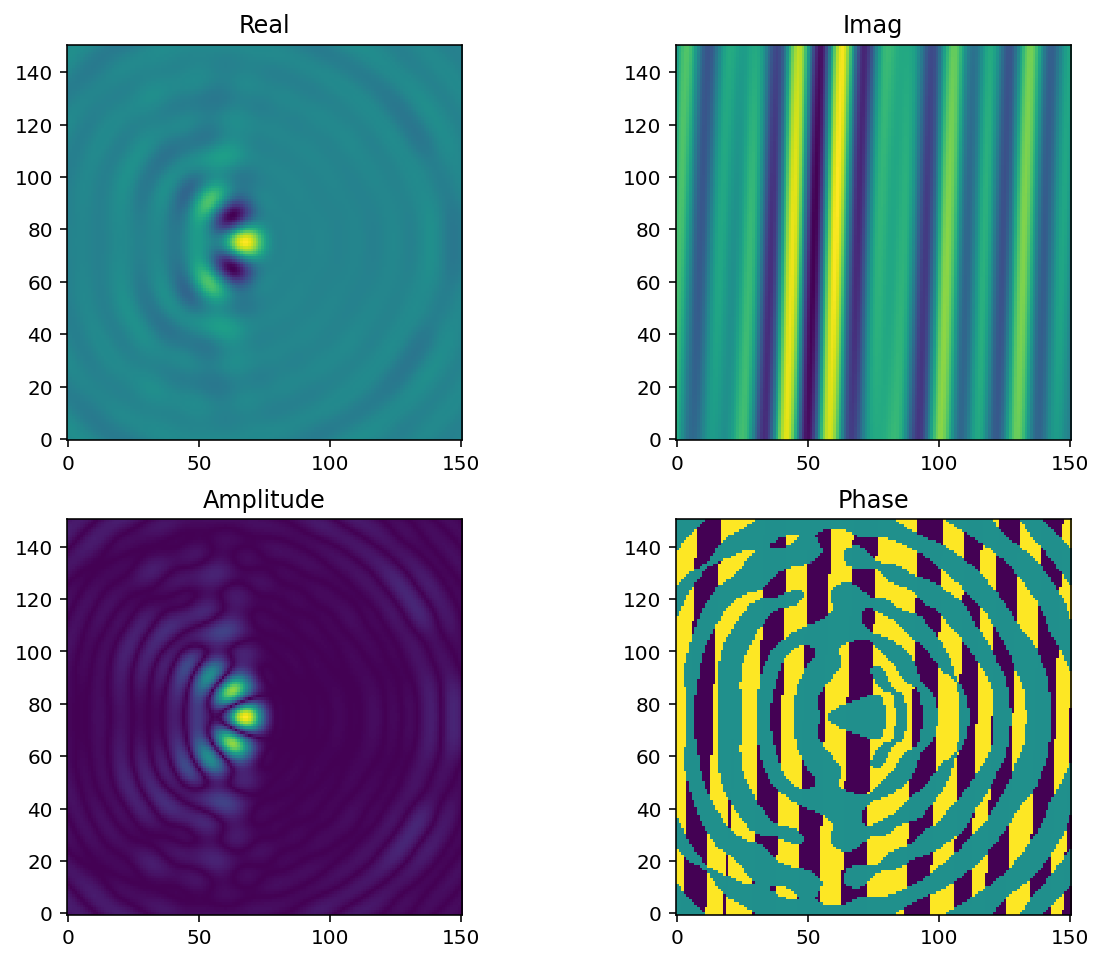

Planet at F


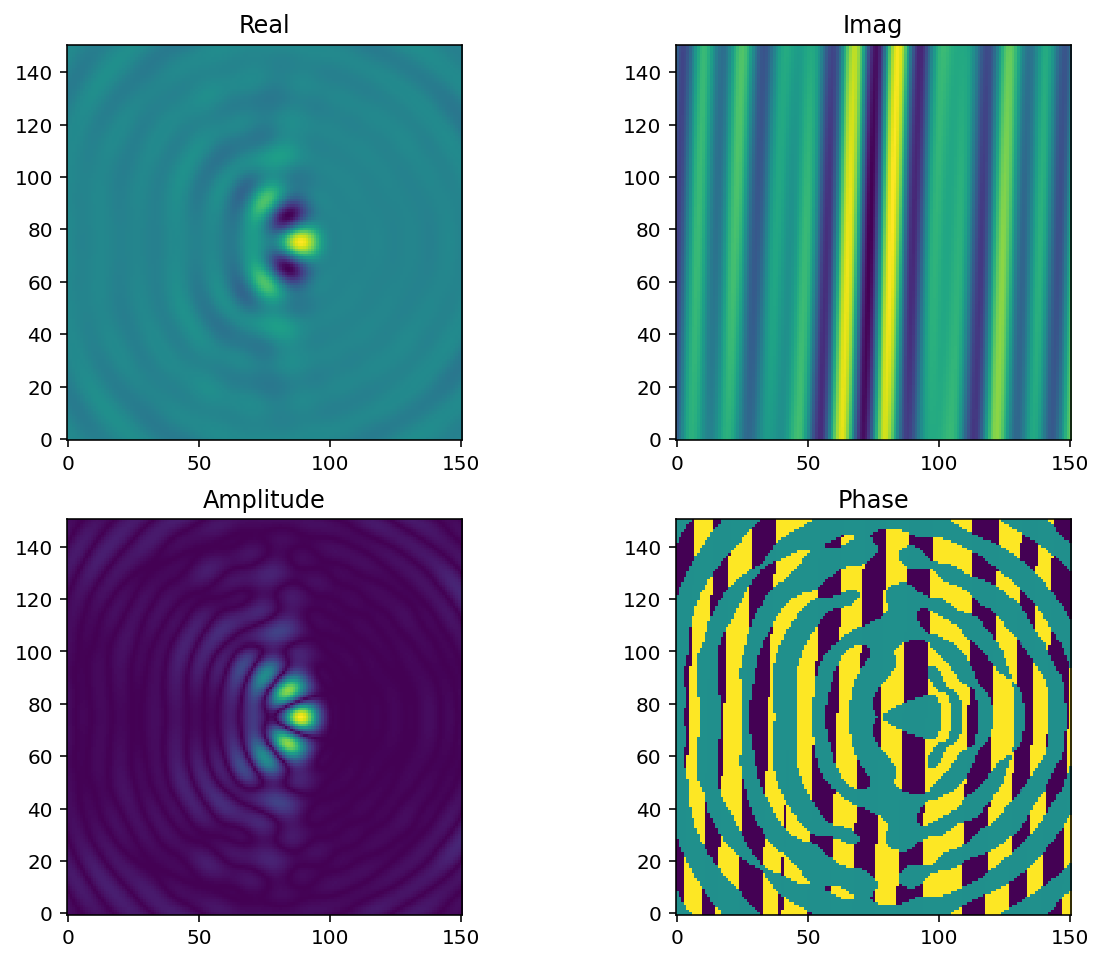

Star and planet at F


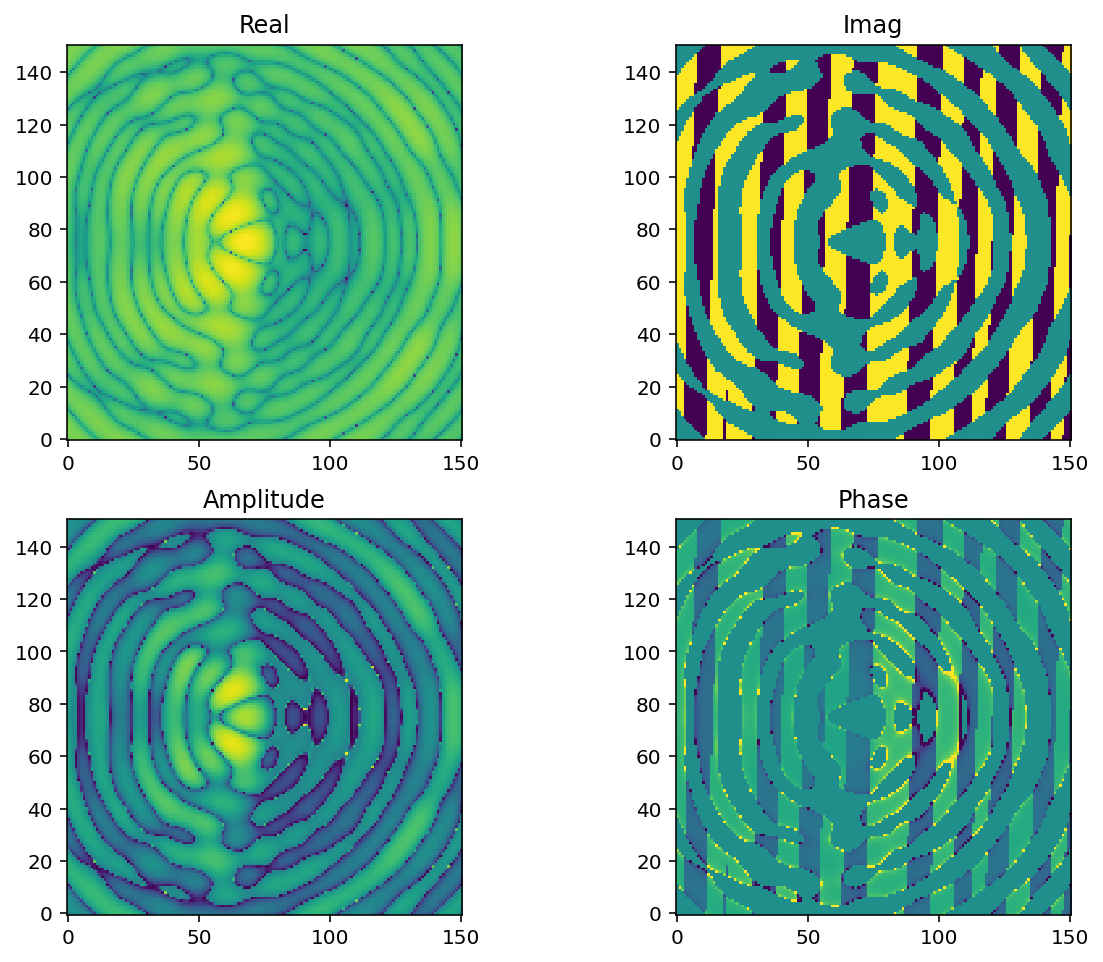

the suppression facor at the peak of star PSF is:  0.253216999525126


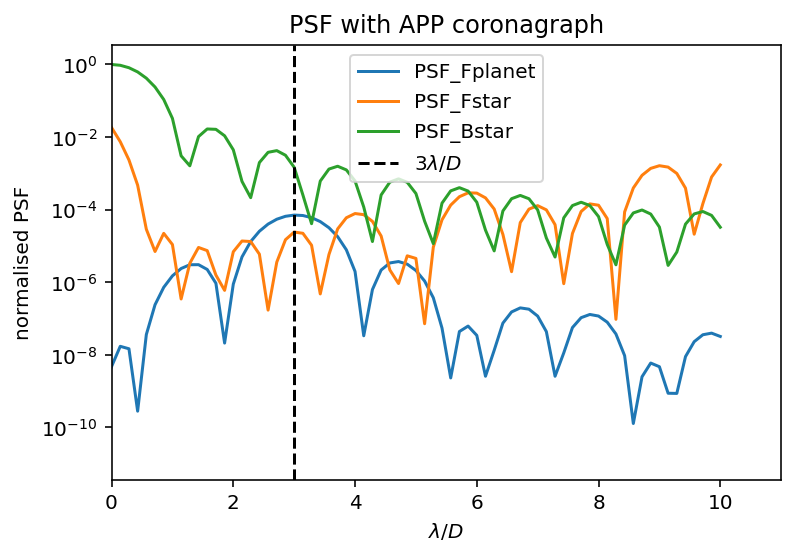

In [12]:
from astropy.io import fits

app_ampl, h1 = fits.getdata('app_ampl.fits',header=True)
app_phse, h2 = fits.getdata('app_phse.fits',header=True)

# Q9 code here
A_star = A.copy()
#tilt=phi_ramp(A_star,.2,0)
#A_star=A_star*np.exp(1j*tilt)
B_star=FFT(A_star, nsamp)
m_app = np.ones_like(B_star)
N_app=app_ampl*np.exp(1j*app_phse)
N_app=padcplx(N_app, nsamp)
displC(N_app,151)

B_star,C_star,D_star,E_star,F_star = coro(A_star,m_app,N_app,nsamp)
B_planet,C_planet,D_planet,E_planet,F_planet = coro(A_planet,m_app,N_app,nsamp)
print("Star at F")
displC(F_star,151)
print("Planet at F")
displC(F_planet,151)
print("Star and planet at F")
displC(np.log10(F_star+F_planet),151)

#PSF
xr=10*nsamp
x=np.arange(-xr,xr+1,1)
incrAp = x/nsamp
PSF_Falanet=xaxis_energy(F_planet,xr)
PSF_Fstar=xaxis_energy(F_star,xr)
PSF_Bstar=xaxis_energy(B_star,xr)
#normalise PSF to the peak of PSF_Bstar
PSF_Falanet=PSF_Falanet/np.max(PSF_Bstar)
PSF_Fstar=PSF_Fstar/np.max(PSF_Bstar)
PSF_Bstar=PSF_Bstar/np.max(PSF_Bstar)
#plot PSF
plt.semilogy(incrAp,PSF_Fplanet, label='PSF_Fplanet')
plt.semilogy(incrAp,PSF_Fstar, label='PSF_Fstar')
plt.semilogy(incrAp,PSF_Bstar, label='PSF_Bstar')
plt.axvline(x=3,ls='--',color='k',label='3$\lambda/D$')
plt.legend()
plt.xlim([0,None])
plt.xlabel('$\lambda/D$')
plt.ylabel('normalised PSF')
plt.title("PSF with APP coronagraph")


suppression2=PSF_Fstar.max()/PSF_Bstar.max()
print("the suppression facor at the peak of star PSF is: ", suppression2)


# Q9 end of code

## Adding tip tilt error to the star

---
<span style="  font-size:2em; color: SteelBlue;">Question 4.10</span> <span style="  font-size:1em; color: SteelBlue;">
(4 points): </span>

**Qualitatively describe what happens to the star flux in the Vortex and APP coronagraphs if you add $0.2 \lambda/D$ tilt in the x direction to the star's wavefront.**

**Answer the question: What does this (this = see what you need to describe) say about the tip tilt stability required for each of the coronagraphs?**


<div class="alert alert-block alert-info">
<b>TIP:</b> You can add the tilt in the code above, then comment it out again when you want the on-axis performance back. </div>

---

In [13]:
# Q10 answer here

print("Qualitatively describe what happens to the star flux in the Vortex and APP coronagraphs if you add 0.2 lambda/D tilt in the x direction to the star's wavefront.\n")
print("Discription: When adding a tilt to the vortex coronagraph, the peak intensity increased almost 100 times, i.e. the suppression is less effective and the result is worse. As for the APP coronagraph, the suppression after adding the  tilt is almost uncahnging, i.e. the  APP coronagraph is insensitive to the tilt error of the star.")
print("\nWhat does this say about the tip tilt stability required for each of the coronagraphs?\n")
print("The above shows that for the vortex coronagraph, tilt error in the star can be important, and should be corrected, asking for a high level of tilt stability; for the APP ccoronagraph, tilt error is trivial, and the required tilt stability is lower.")
# Q10 end of answer


Qualitatively describe what happens to the star flux in the Vortex and APP coronagraphs if you add 0.2 lambda/D tilt in the x direction to the star's wavefront.

Discription: When adding a tilt to the vortex coronagraph, the peak intensity increased almost 100 times, i.e. the suppression is less effective and the result is worse. As for the APP coronagraph, the suppression after adding the  tilt is almost uncahnging, i.e. the  APP coronagraph is insensitive to the tilt error of the star.

What does this say about the tip tilt stability required for each of the coronagraphs?

The above shows that for the vortex coronagraph, tilt error in the star can be important, and should be corrected, asking for a high level of tilt stability; for the APP ccoronagraph, tilt error is trivial, and the required tilt stability is lower.



<div class="alert alert-block alert-info">
<b>REMEMBER:</b> to make sure your code compiles cleanly before submitting it!</div>


---
<span style="  font-size:2em; color: SteelBlue;">Your time has a value as well</span> 
 </span>

---

### How long did this Practicum take?
Please enter the number of hours you spent on this Practicum (including the time spend besides the time spend during the Lecture) below:


Number of hours taken for this practicum: ~ 8 hours.
